### Calc scores end errors of the test trajectories

to be used for the histograms

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]
import time

data_path = "../../../data_PHELPH/"
derrom_path = "../../"

import sys

# sys.path.append(derrom_path)
sys.path.insert(0,derrom_path)

import derrom
from derrom.utils import ivp_integrator
import PHELPH

In [2]:
kmax = 2.5
n_kmax = 100

tmax = 10000
n_tmax = 1001
dt = tmax/(n_tmax-1)
t_vec = np.linspace(0,tmax,n_tmax)

system = PHELPH.PHELPH(kmax=kmax, n_kmax=n_kmax)

v = 'v2'
system.g_photon = 0.04
system.tau_photon = 200
system.E_photon = 0.035
system.linewidth = 0.01

system.setup_laser()

In [3]:
I_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_I_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_trajectories = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_kmax2.5_nkmax_100_n1000_'+v+'.npz')
el_scattering = derrom.utils.load_trajectories(filename=data_path + 'PHELPH_el_scat_kmax2.5_nkmax_100_n1000_'+v+'.npz')

n_trajectories = len(el_trajectories)
n_kmax = el_trajectories[0].shape[1]
print(n_trajectories, 'loaded with n_kmax =', n_kmax)

trajectories = [ np.concatenate([el_trajectories[k],I_trajectories[k].reshape(-1,1)], axis=1) for k in range(n_trajectories) ]

# n_sample = 100
# I_trajectories = I_trajectories[::n_sample]
# el_trajectories = el_trajectories[::n_sample]
# el_scattering = el_scattering[::n_sample]

n_sample = 50
n_start = 0

train_I_trajectories = I_trajectories[n_start:n_start+n_sample]
train_el_trajectories = el_trajectories[n_start:n_start+n_sample]
train_el_scattering = el_scattering[n_start:n_start+n_sample]
train_trajectories = trajectories[n_start:n_start+n_sample]
print('number of training trajectories: ', len(train_trajectories))

test_start = n_sample
test_I_trajectories = I_trajectories[test_start:]
test_el_trajectories = el_trajectories[test_start:]
test_el_scattering = el_scattering[test_start:]
test_trajectories = trajectories[test_start:]
print('number of test trajectories: ', len(test_trajectories))

median_test_I_max = np.median([I.max() for I in test_I_trajectories])
median_test_I_max_pos = np.median([np.argmax(I)*dt for I in test_I_trajectories])


1000 loaded with n_kmax = 100
number of training trajectories:  50
number of test trajectories:  950


In [4]:
el_scat_model = derrom.estimator(rdim=8, DE_l=2, intercept=True, full_hist=False,
                    optimizer=derrom.optimizers.ridge(alpha=10.**1),
                    scaler=derrom.scalers.standardize_scaler(1.0),
                    dim_reducer=derrom.dim_reducers.SVD(),
                    NL_transformer=derrom.transformers.ELM_features(ELM_nodes=1000))

def derivs(y):   
    el_hist = y[:,:-1]
    el_state = y[-1,:-1]
    I = y[-1,-1]

    df = el_scat_model.predict(el_hist)
    df += -system.g_photon * I * system.lineshape_vec * (2.*el_state - 1.0)


    dI = -I/system.tau_photon + I * np.sum(system.I_gain_helper_vec * (2.*el_state - 1.0))
    dI += 1e-9

    return np.concatenate((df[0],[dI]))

integrator = derrom.utils.PHELPH_ivp_integrator(el_scat_model, derivs, dt=5.0, dt_out=10., method='Heun')

### Parameters:
determined from model optimization notebook

n100: rdim=10, a=2\
n50: rdim=8, a=1\
n20: rdim=4, a=2\
n10: rdim=4, a=0

In [5]:
el_scat_model.fit(train_el_trajectories, train_el_scattering)

In [6]:
el_scat_model.print_status()

full_hist:  True
intercept:  True
standardize:  True
rdim:  8
DE_l:  2
weights shape:  (1017, 100)


el rms error: 0.005959221702662937
I_max error: -3.572510533480372e-06
I_max_pos error: 10.0


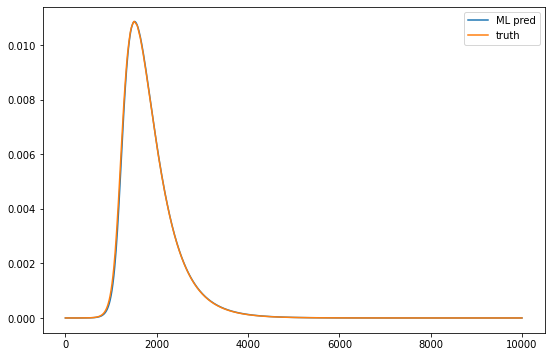

In [7]:
ind = -1

test_el_trajectory = test_el_trajectories[ind]
test_I_trajectory = test_I_trajectories[ind]
test_trajectory = test_trajectories[ind]

inits = test_trajectory[:1]

pred = integrator.integrate(test_trajectory,test_trajectory.shape[0])

print('el rms error:', integrator.get_error(test_trajectory,pred, norm='rms'))
print('I_max error:', integrator.get_error(test_trajectory,pred, norm='I_max'))
print('I_max_pos error:', integrator.get_error(test_trajectory,pred, norm='I_max_pos'))

plt.plot(t_vec,pred[:,-1],label='ML pred')
plt.plot(t_vec,test_I_trajectory,label='truth')
plt.legend()
plt.show()

In [12]:
I_max_errs = []
I_max_pos_errs = []
el_rms_errs = []

t_start = time.time()

for test in test_trajectories:
    pred = integrator.integrate(test, test.shape[0])
    I_max_errs.append(integrator.get_error(test,pred, norm='I_max'))
    I_max_pos_errs.append(integrator.get_error(test,pred, norm='I_max_pos'))
    el_rms_errs.append(integrator.get_error(test,pred, norm='rms'))
    
t_end = time.time()
print("computation time:", t_end - t_start)

computation time: 643.599198102951


In [13]:
I_max_scores = np.abs(I_max_errs)/median_test_I_max
I_max_pos_scores = np.abs(I_max_pos_errs)/median_test_I_max_pos

scores = np.stack([I_max_scores, I_max_pos_scores, el_rms_errs],axis=0)
errs = np.stack([I_max_errs, I_max_pos_errs, el_rms_errs],axis=0)
print(scores.shape)

(3, 950)


In [14]:
# np.savetxt(data_path+'PHELPH_test_scores_n50', scores)
# np.savetxt(data_path+'PHELPH_test_errs_n50', errs)

0.12337098830330029
0.046632124352331605
0.1700031126556319


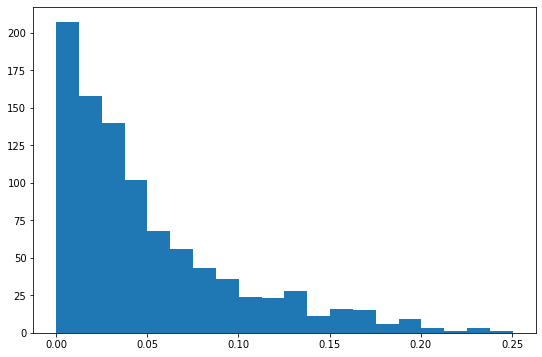

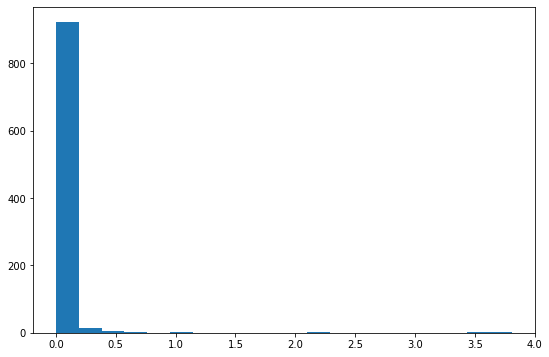

In [15]:
I_max_scores_90ths = np.percentile(I_max_scores, 90)
I_max_pos_scores_90ths = np.percentile(I_max_pos_scores, 90)

print(I_max_scores_90ths)
print(I_max_pos_scores_90ths)
print(I_max_scores_90ths + I_max_pos_scores_90ths)

plt.hist(I_max_scores, bins = 20)
plt.show()

plt.hist(I_max_pos_scores, bins=20)
plt.show()